# 🕺  It's a high time to try ML for TS.
So, where are we? Let me revise you a bit:
- We have understood the concept of **holt** models and so the EWMA
- Then got hands on the **ARIMA** and seen the seasonal function of it
- ARIMA can be **pretty intrepretable** as well
- Then seen the **auto-ARIMA** and the grid search
- We saw how ML models fail in **extrapolation** badly
- Now, it is the time to see them **working in action** with the real data.

### TL;DR
The ML models ***can*** be used for the time-series if used properly. Now, what is "properly"?

Simply, they fail when used in the **non-differenced** data *(as we will see)* but, if you use them in the **differenced** data then they **work!**. And that's the agenda of this book. So, let's see how.

*(Before making this book, I have already made a long book on this but as said, "long" it felt me so boring. So I deleted it. In here, I want to make is small and compact; instead of trying all models in all situations.)*

In [219]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.multioutput import MultiOutputRegressor

In [89]:
# loading the data
df = pd.read_csv("../data/airline_passengers.csv", index_col=0, parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 1️⃣  ML Performance without differencing

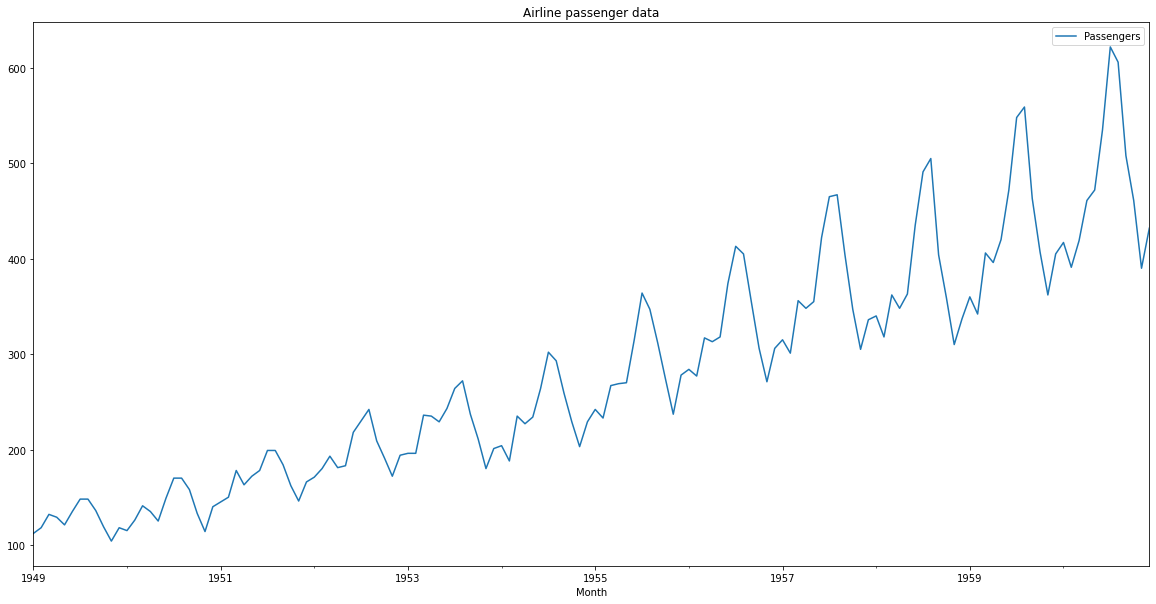

In [90]:
# data
df.plot()
plt.title("Airline passenger data");

In [91]:
# numpy conversion for easy indexing
data = df.Passengers.values

# storing the train and test index for plotting
train_idx = df.iloc[:-12].index
test_idx = df.iloc[-12:].index

We can **predict** the values in 3 ways:
1. One step forecast
2. Multi step forecast
3. Multi output forecast (MTR 😉)

From which we know the OneStep and MultiStep. 
1. **One Step**: Here, we only predict the next single point.
2. **Multi Step**: Take the prediction of previous as an input of this model *(as done in AR(p) example)*
3. **Multi Output**: Train multiple models for multiple points and predict at once. *(This is exactly the MTR that I am researching now-a-days)*

In [92]:
# data transformation into a supervised learning
lag = 10 # taking past 10 data 
X = []
y = []

for offset in range(0, len(data) - lag):
    X.append(data[offset : offset + lag])
    y.append(data[offset + lag])

X = np.array(X)
y = np.array(y)

In [93]:
# data splitting
Xtrain = X[:-12]
ytrain = y[:-12]
Xtest = X[-12:]
ytest = y[-12:]

### `1.` One step

In [94]:
lr = LinearRegression().fit(Xtrain, ytrain)

# this is for the one step only. Don't use Xtest as it involves
# the real world test data and usually results in high accuracy
lr_pred_test = lr.predict(Xtest)
lr_pred_train = lr.predict(Xtrain)

In [95]:
# testing prediction
lr.score(Xtest, ytest)

0.7209726942717989

In [96]:
# training prediction
lr.score(Xtrain, ytrain)

0.9522892096975738

We can see there is `0.72` R2 score. Which is pretty good compared to what we are gonna see in the *multi-step* format.

In [97]:
df.loc[train_idx[lag:], "Train Forecast"] = lr_pred_train
df.loc[test_idx, "Test Forecast (1Step)"] = lr_pred_test

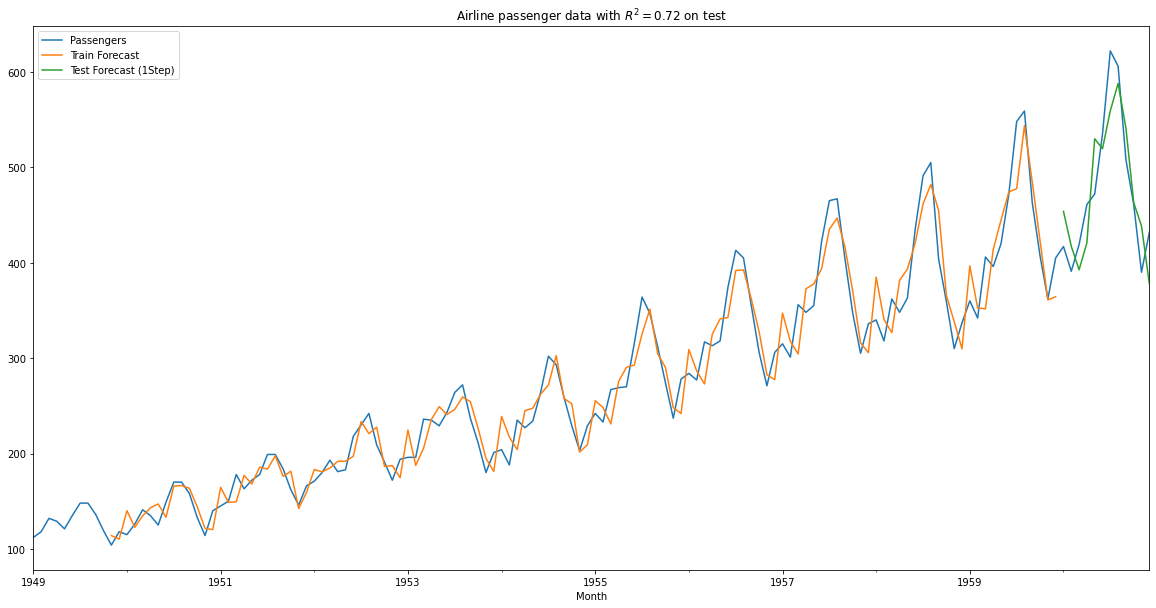

In [98]:
df.plot()
plt.title(f"Airline passenger data with $R^2 = {round(r2_score(ytest, lr_pred_test), 2)}$ on test");

### `2.` Multi Step

In [99]:
lr = LinearRegression().fit(Xtrain, ytrain)

In [100]:
# as we know, for multistep we will need to predict and reuse that prediction

# saving the last X as in the updatable form
last_X = Xtest[-1]
multi_step_preds = []
for _ in range(12): # as we will make 12 predictions
    prediction = lr.predict(last_X.reshape(1, -1))[0]
    multi_step_preds.append(prediction)
    last_X = np.roll(last_X, -1)
    last_X[-1] = prediction

In [101]:
df.loc[test_idx, "Test Forecast (MultiStep)"] = multi_step_preds

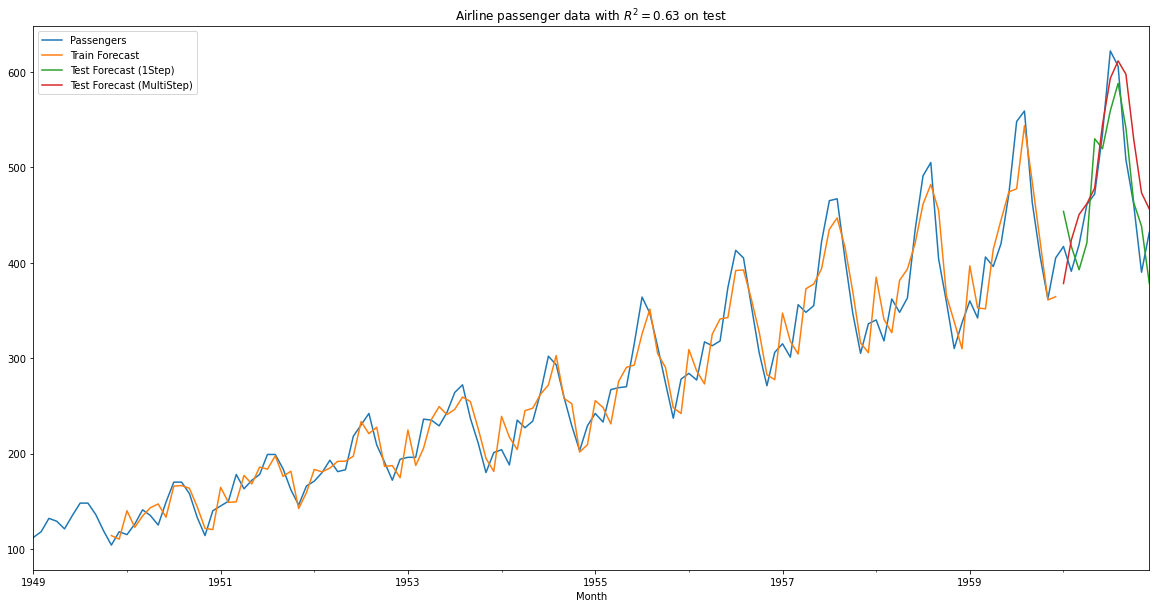

In [103]:
df.plot()
plt.title(f"Airline passenger data with $R^2 = {round(r2_score(ytest, multi_step_preds), 2)}$ on test");

It looks better fit on the test data *(red line)* but the R2 score suggests that it is not. The One-Step performed better as it should be.

### `3.` Multi Output

In [107]:
# for this we will have to construct another dataset
# the current supervised dataset won't help.

lag = 10
h = 12
X, y = [], []
for offset in range(len(data) - lag - h + 1):
    X.append(data[offset : offset+lag])
    y.append(data[offset+lag : offset+lag+h])
    
X = np.array(X)
y = np.array(y)

In [110]:
X.shape

(123, 10)

In [111]:
y.shape

(123, 12)

See? Something is changed. Here we will traing the `y` as in the vector. It is not hard. It is just taking `h` ys and to make it predictable together.

In [115]:
Xtrain_m = X[:-1]
ytrain_m = y[:-1]
Xtest_m = X[-1]
ytest_m = y[-1]

You are getting the indices above, right 🤔 <br>
They are pretty straight-forward.

In [116]:
lr = LinearRegression().fit(Xtrain_m, ytrain_m)

In [121]:
mtr_pred = lr.predict(Xtest_m.reshape(1, -1))

In [124]:
r2_score(ytest_m, mtr_pred.flatten())

0.8810151391474773

This is the highest. Really.

In [125]:
df.loc[test_idx, "Test Forecast (MTR)"] = mtr_pred.flatten()

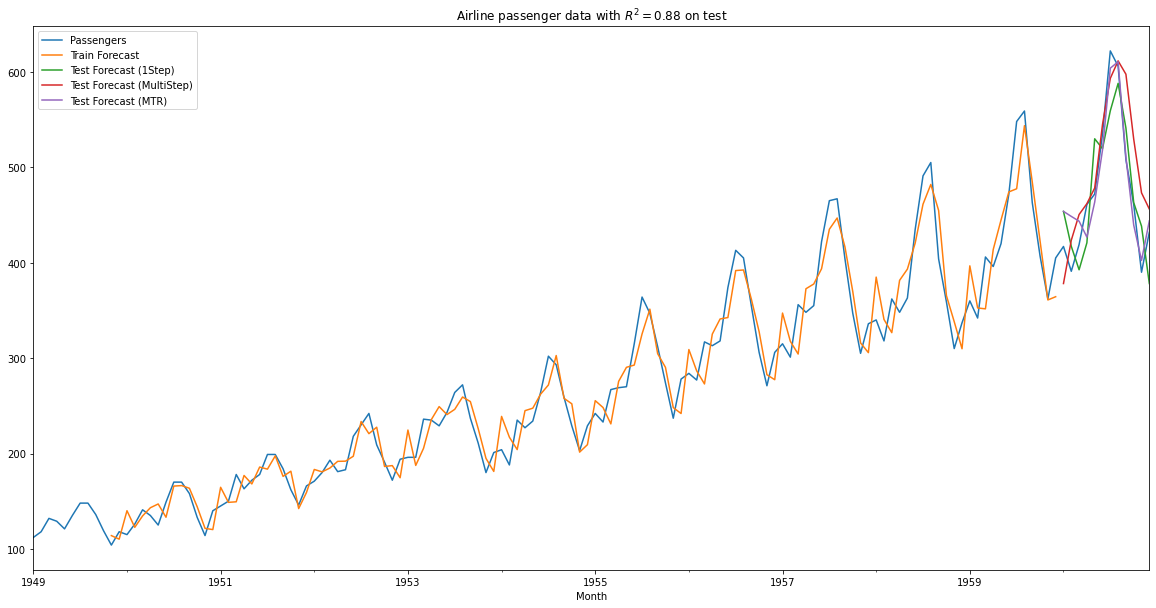

In [127]:
df.plot()
plt.title(f"Airline passenger data with $R^2 = {round(r2_score(ytest_m, mtr_pred.flatten()), 2)}$ on test");

Don't know if you can see the **purple** line or not... but according to the R2, it is the best test accuracy so far.

> You know what? I actually want to stop my self here... but I am willing to make a class to test all models. Let's see how that goes. Sorry, the promise that I made earlier in this book to *"make this book compact"* will no longer applicable.

In [143]:
from copy import copy

In [221]:
class Train_Predict_Plot_Evaluate:
    """
    This class does everything.
    Use with care.
    
    __init__ args:
    
    1. data: Whole data
    2. Model: The model
    
    It will transform the data into different types
    of supervised problems automatically.
    
    Then the rest is the history. I catually want to
    write more in this doc, but see the execution below
    so you no longer need to read this boring text.
    """
    
    def __init__(self, data, index, model):
        # no need to perform type checks as this is not
        # a library. Only for the internal use
        self.model = model
        self.data = data
        self.plottable = pd.DataFrame(data.reshape(-1, 1), index=index, columns=["Passangers"])
        
        # make supervised for one_step/multi_step
        self.Xtrain, self.Xtest, self.ytrain, self.ytest = \
            self.transform_to_sup_1(data, lag=10, h=12)
        
        # make supervised for multi_output (MTR)
        self.Xtrain_m, self.Xtest_m, self.ytrain_m, self.ytest_m = \
            self.transform_to_sup_2(data, lag=10, h=12)
        
        
    def transform_to_sup_1(self, data, lag, h):
        X, y = [], []
        for offset in range(0, len(data) - lag):
            X.append(data[offset : offset + lag])
            y.append(data[offset + lag]) 
        X = np.array(X)
        y = np.array(y)

        Xtrain = X[:-h]
        ytrain = y[:-h]
        Xtest = X[-h:]
        ytest = y[-h:]    
        return Xtrain, Xtest, ytrain, ytest
    
    
    def transform_to_sup_2(self, data, lag, h):
        X, y = [], []
        for offset in range(len(data) - lag - h + 1):
            X.append(data[offset : offset+lag])
            y.append(data[offset+lag : offset+lag+h])
        X = np.array(X)
        y = np.array(y)
        
        Xtrain_m = X[:-1]
        ytrain_m = y[:-1]
        Xtest_m = X[-1]
        ytest_m = y[-1]
        return Xtrain_m, Xtest_m, ytrain_m, ytest_m
    
    def fit(self):
        self.model1 = copy(self.model) # for one_step and multi_step
        self.model2 = copy(self.model) # for multi_output
        
        # training both models
        self.model1.fit(self.Xtrain, self.ytrain)
        
        # if incase model natively doesn't support MTR
        try:
            self.model2.fit(self.Xtrain_m, self.ytrain_m)
        except:
            self.model2 = MultiOutputRegressor(self.model2)
            self.model2.fit(self.Xtrain_m, self.ytrain_m)
            
        return "Training done!"
    
    def predict(self, model_name):
        # for 1-step
        one_step_preds = self.model1.predict(self.Xtest)
        
        # for multi-step
        last_X = self.Xtest[-1]
        multi_step_preds = []
        for _ in range(12): # as we will make 12 predictions
            prediction = self.model1.predict(last_X.reshape(1, -1))[0]
            multi_step_preds.append(prediction)
            last_X = np.roll(last_X, -1)
            last_X[-1] = prediction
            
        # for multi-output
        multi_output_preds = self.model2.predict(self.Xtest_m.reshape(1, -1))
        
        
        # storing
        self.plottable.loc[self.plottable.index[-12:], "One Step"] = one_step_preds
        self.plottable.loc[self.plottable.index[-12:], "Multi Step"] = multi_step_preds
        self.plottable.loc[self.plottable.index[-12:], "Multi Output"] = multi_output_preds.flatten()
        
        # score
        onestep_r2 = round(r2_score(self.ytest, one_step_preds), 2)
        multistep_r2 = round(r2_score(self.ytest, multi_step_preds), 2)
        multioutput_r2 = round(r2_score(self.ytest, multi_output_preds.flatten()), 2)
        
        # plotting
        self.plottable.plot()
        plt.figtext(0.5, 0.885, 
                    model_name, 
                    fontsize=15, ha="center")
        plt.figtext(0.5, 0.86, 
                    f"Onestep: {onestep_r2}  |  MultiStep: {multistep_r2}  |  MultiOutput: {multioutput_r2}",
                    fontsize=12, ha="center")
        plt.subplots_adjust(top=0.85);

Alrighty! Looks cool till now. Let's shoot!

### `1.` Linear Regression

In [222]:
obj = Train_Predict_Plot_Evaluate(data, df.index, LinearRegression())
obj.fit()

'Training done!'

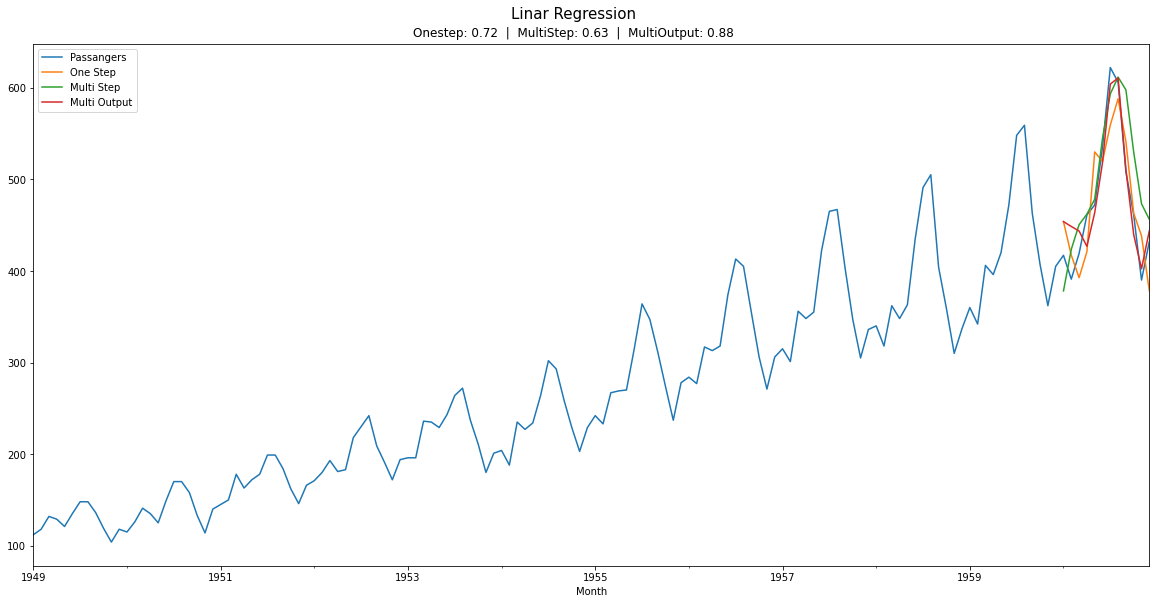

In [223]:
obj.predict("Linar Regression")

Amazing, these are the same results which we have already seen.

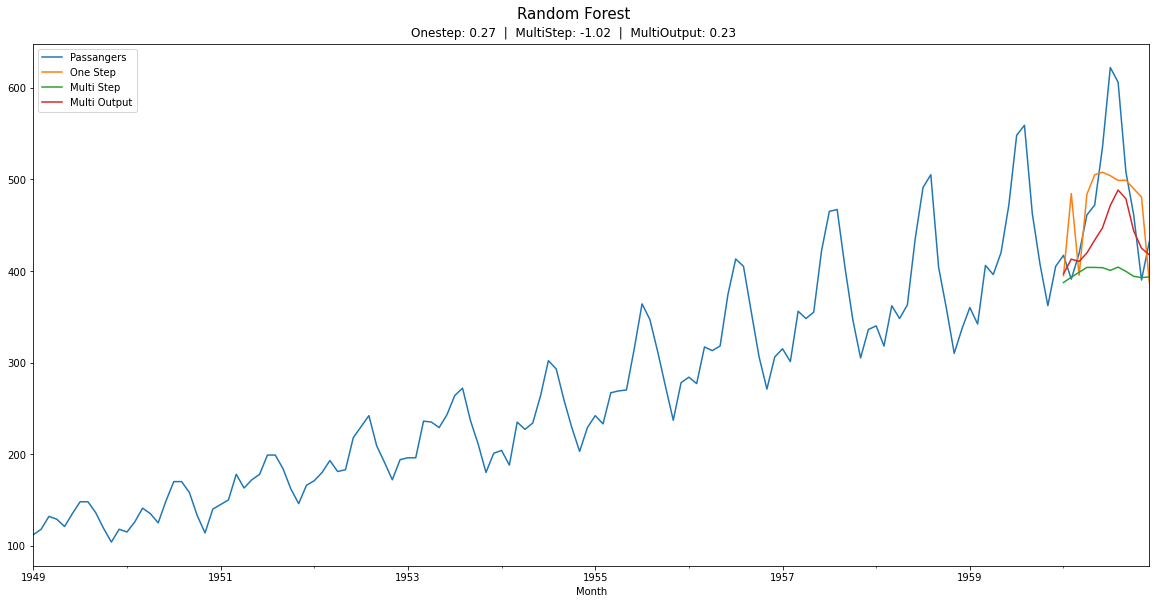

In [208]:
obj = Train_Predict_Plot_Evaluate(data, df.index, RandomForestRegressor())
obj.fit()
obj.predict("Random Forest")

It has poor results. Still the one-step performs better than the rest. <br>
Of course, with some tweaking we *may* get the better results... but I don't think that also can increase the chances.

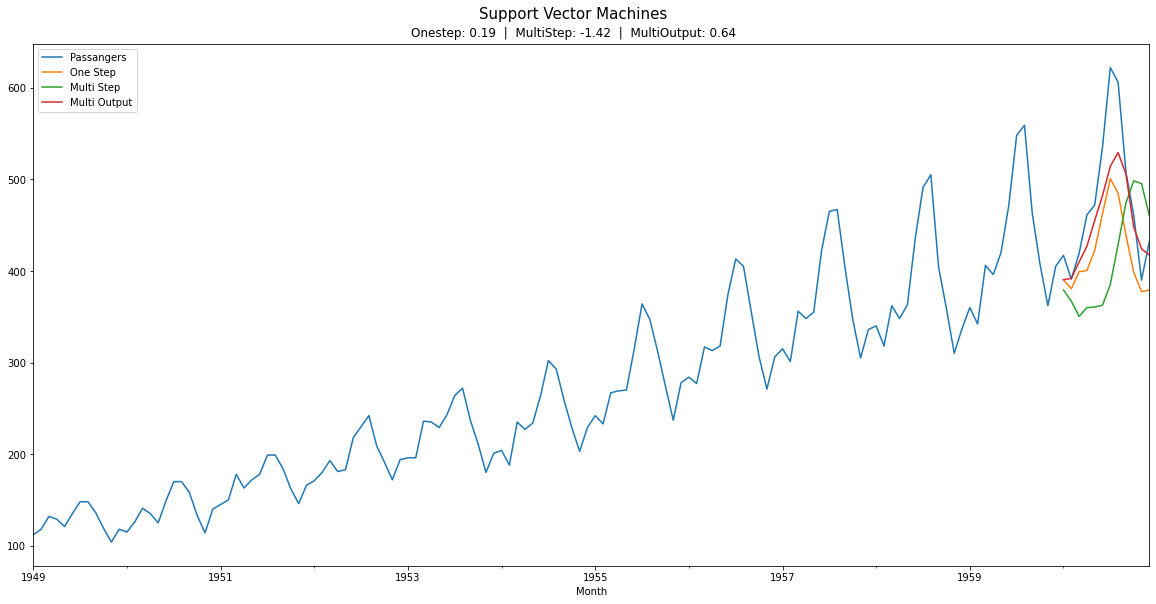

In [225]:
obj = Train_Predict_Plot_Evaluate(data, df.index, SVR(C=100))
obj.fit()
obj.predict("Support Vector Machines")

As we know, the SVR doesn't ***support*** multi-target regression. We can't use it here. We might want to make it usable by `MultiOutputRegression` class.

So, our class has made that usinf the `MOR` and the results are here. 
> NOTE: I have done some setting of `C` hyperparameter in the SVR otherwise the results were ***scary***.

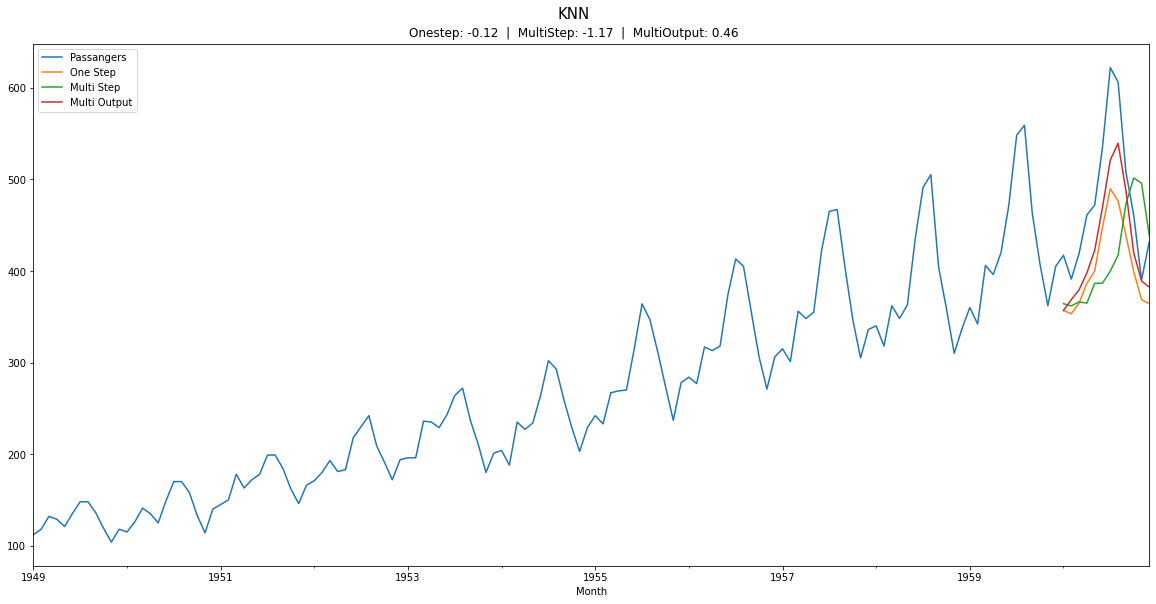

In [226]:
obj = Train_Predict_Plot_Evaluate(data, df.index, KNeighborsRegressor())
obj.fit()
obj.predict("KNN")

Oh! MultiOutput does a better job here. But still not the satisfactory.

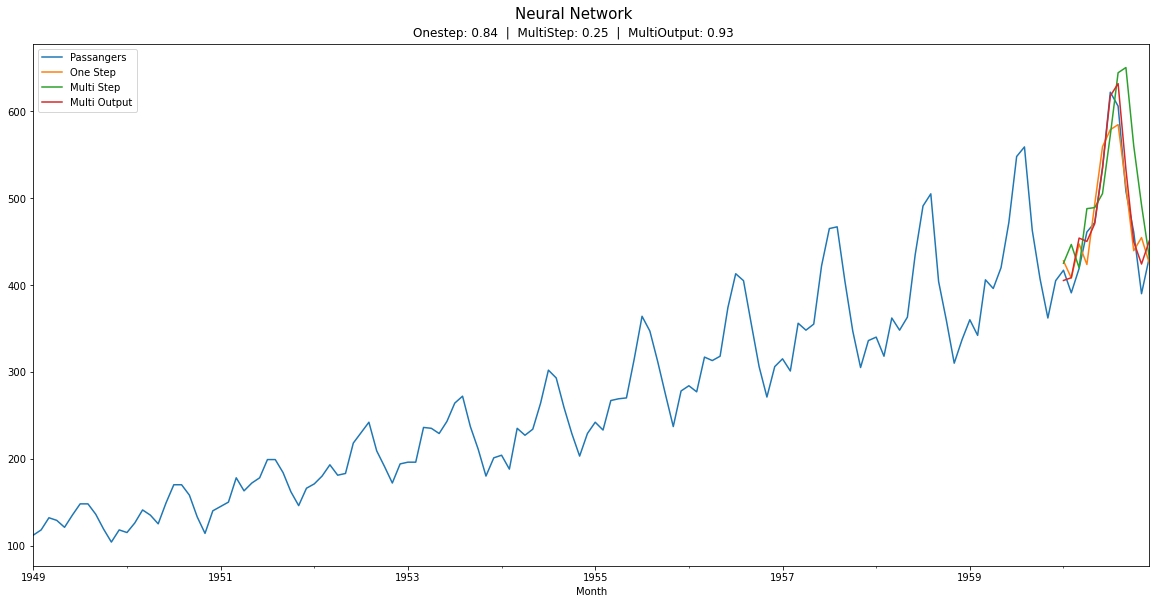

In [232]:
obj = Train_Predict_Plot_Evaluate(data, df.index, MLPRegressor(max_iter=5000, random_state=42))
obj.fit()
obj.predict("Neural Network")

**BEST** of all. Of course some parameters were tuned... but still it is good. Multi output gives the best result.

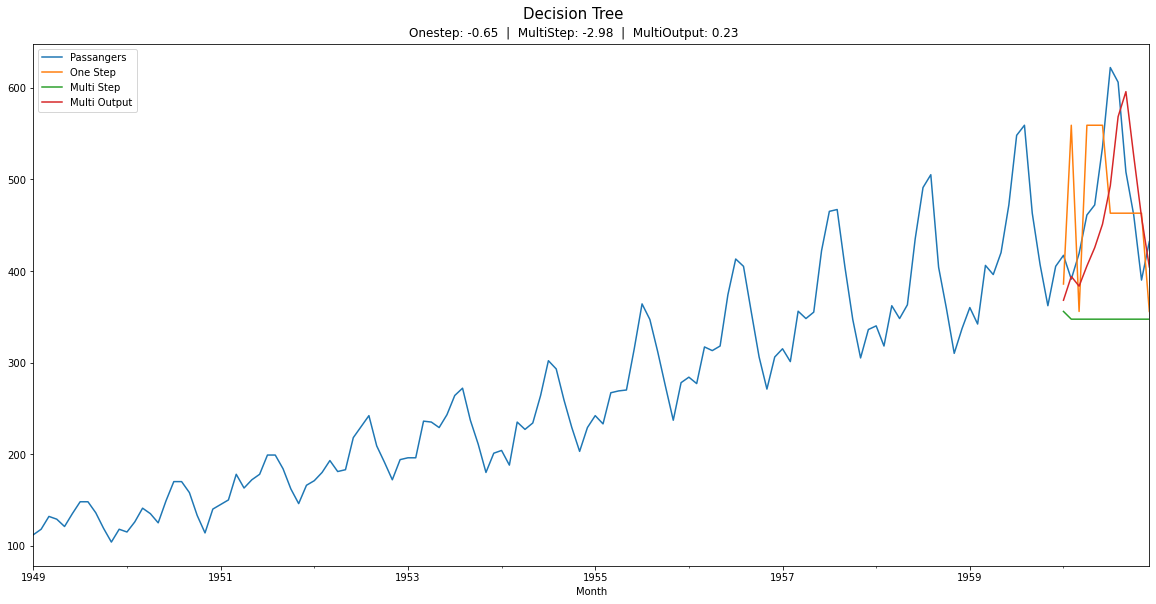

In [233]:
obj = Train_Predict_Plot_Evaluate(data, df.index, DecisionTreeRegressor(max_depth=5))
obj.fit()
obj.predict("Decision Tree")

Overfits!

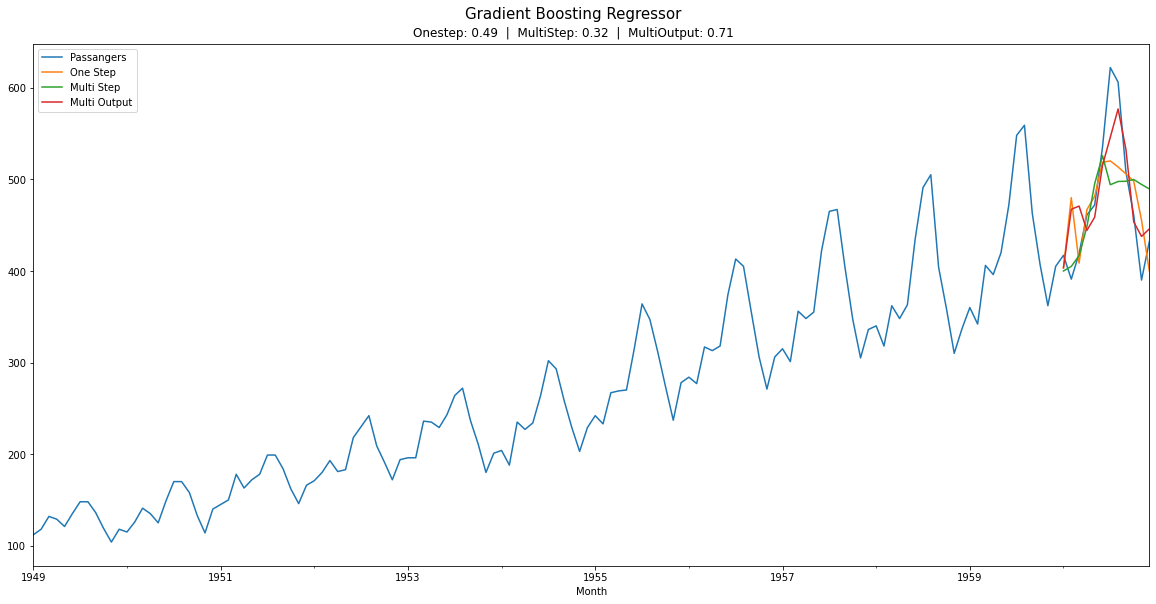

In [234]:
obj = Train_Predict_Plot_Evaluate(data, df.index, GradientBoostingRegressor())
obj.fit()
obj.predict("Gradient Boosting Regressor")

Alrighty!

### Good job!
We have seen multiple models some of which performs poor and others quite good. Except the neural network... I did some tuning but if we still do that for other models we might expect better results. But still, in the next section we will see how the results change when applied **differencing**.